In [126]:
from __future__ import (absolute_import, division, print_function)
from six.moves import (filter, input, map, range, zip)  # noqa

import iris
import cf_units
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt

import numpy
import cartopy.crs as ccrs

import cf_units
from iris.analysis.cartography import cosine_latitude_weights

import math
import seaborn

In [63]:
%matplotlib inline

## Read data

In [64]:
fname = '/g/data/r87/dbi599/argo_ohc_maps.nc'
cube = iris.load_cube(fname, 'ocean heat content')

In [65]:
print(cube)

ocean heat content / (10^12 J m-2)  (time: 144; latitude: 130; longitude: 360)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Scalar coordinates:
          depth: 1005.62 dbar, bound=(-1.25, 2012.5) dbar
     Attributes:
          Conventions: CF-1.5
          comment: ARGO TEMPERATURE ANOMALY defined by Jan 2004 - Dec 2014 (11.0 year) RG...
          depth_bounds: OHC integrated over full depth of input data (2.500000 down to 1975.00...
          history: Wed May 04 13:04:17 2016: /g/data/r87/dbi599/miniconda2/envs/default/bin/python...
          invalid_standard_name: ocean_heat_content


In [66]:
print(cube[0])

ocean heat content / (10^12 J m-2)  (latitude: 130; longitude: 360)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          depth: 1005.62 dbar, bound=(-1.25, 2012.5) dbar
          time: 2004-01-16 05:14:31.902458
     Attributes:
          Conventions: CF-1.5
          comment: ARGO TEMPERATURE ANOMALY defined by Jan 2004 - Dec 2014 (11.0 year) RG...
          depth_bounds: OHC integrated over full depth of input data (2.500000 down to 1975.00...
          history: Wed May 04 13:04:17 2016: /g/data/r87/dbi599/miniconda2/envs/default/bin/python...
          invalid_standard_name: ocean_heat_content


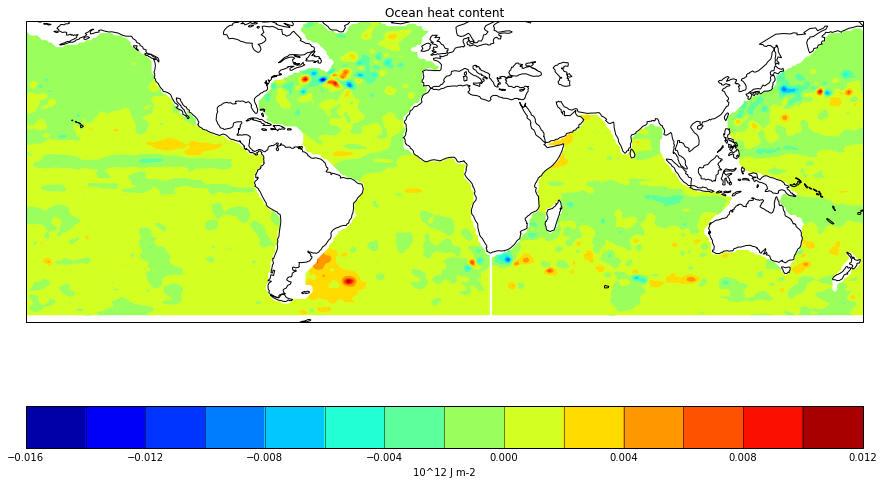

In [67]:
#cmap = getattr(plt.cm, 'hot_r')

fig = plt.figure(figsize=(15, 10))
plt.subplot(111)
qplt.contourf(cube[3], 15)# cmap=cmap)
plt.gca().coastlines()

# Plot #2: contourf with axes longitude from 0 to 360
#proj = ccrs.PlateCarree(central_longitude=-180.0)
#ax = plt.subplot(122, projection=proj)
#qplt.contourf(temperature, 15)
#plt.gca().coastlines()
iplt.show()

In [68]:
print(cube.shape)

(144, 130, 360)


## Calculate and plot trend

In [69]:
def polyfit(data, time_axis):
    """Fit polynomial to data."""    

    if data.mask[0]:
        return data.fill_value
    else:    
        return numpy.polynomial.polynomial.polyfit(time_axis, data, 1)[-1]

The relationship between Watts and Joules is $W = J s^{-1}$...

In [78]:
cube_J = cube * 10**12

time_axis = cube_J.coord('time')
print(time_axis.points[0:3])

new_unit = cf_units.Unit('seconds since 2004-01-01 00:00:00', calendar='gregorian')  
time_axis.convert_units(new_unit)

print(time_axis.points[0:3])

trend = numpy.ma.apply_along_axis(polyfit, 0, cube_J.data, time_axis.points)
trend = numpy.ma.masked_values(trend, cube_J.data.fill_value)

[ 15.2184248   45.65527344  76.09212494]
[ 1314871.875  3944615.5    6574359.5  ]


In [79]:
trend.shape

(130, 360)

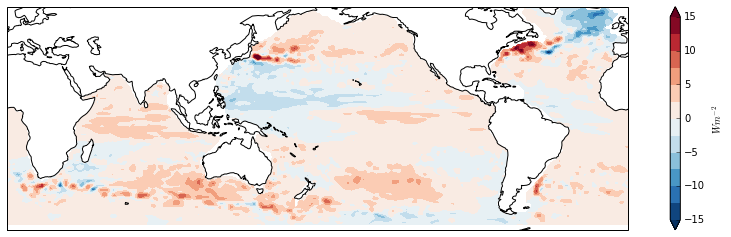

In [96]:
fig = plt.figure(figsize=[15, 4])

nrows = 1
ncols = 1
plotnum = 1
ax = plt.subplot(nrows, ncols, plotnum, projection=ccrs.PlateCarree(central_longitude=180.0))

x = cube.coord('longitude').points
y = cube.coord('latitude').points

cmap = plt.cm.RdBu_r
#cmap.set_bad('blue')
#cmap.set_over('blue')
#cmap.set_under('blue')
ticks = numpy.arange(-15, 17.5, 2.5)

cf = ax.contourf(x, y, trend, transform=ccrs.PlateCarree(),
                 cmap=cmap, levels=ticks, extend='both')
plt.gca().coastlines()
cbar = plt.colorbar(cf)
cbar.set_label('$Wm^{-2}$')
plt.show()

In [97]:
print(trend.max())
print(trend.min())

22.1514596779
-18.6695611289


## Calculate the zonal mean heat gain

In moving from $W m^{-2}$ to $W m^{-1}$ need to account for the fact that the length of a degree of longitude is a function of latitude. The formula for the length of one degree of longitude is $(\pi / 180) a \cos{\phi}$, where $a$ is the radius of the earth and $\phi$ is the latitude.

In [105]:
weights = cosine_latitude_weights(cube_J)

In [109]:
weights.shape

(144, 130, 360)

In [110]:
iris.analysis.cartography.DEFAULT_SPHERICAL_EARTH_RADIUS

6367470

In [112]:
math.pi

3.141592653589793

In [141]:
#cube_J.coord('longitude').guess_bounds()
level_bounds = cube_J.coord('longitude').bounds
print(level_bounds.shape)

(360, 2)


In [147]:
lon_diffs = numpy.apply_along_axis(lambda x: x[1] - x[0], 1, level_bounds)
lon_diffs = lon_diffs[numpy.newaxis,:]

In [148]:
print(lon_diffs.shape)

(1, 360)


In [149]:
lon_extents = (math.pi / 180.) * iris.analysis.cartography.DEFAULT_SPHERICAL_EARTH_RADIUS * weights[0,:,:] * lon_diffs

In [150]:
lon_extents

array([[ 47844.1328125 ,  47844.1328125 ,  47844.1328125 , ...,
         47844.1328125 ,  47844.1328125 ,  47844.1328125 ],
       [ 49587.44140625,  49587.44140625,  49587.44140625, ...,
         49587.44140625,  49587.44140625,  49587.44140625],
       [ 51315.65625   ,  51315.65625   ,  51315.65625   , ...,
         51315.65625   ,  51315.65625   ,  51315.65625   ],
       ..., 
       [ 51315.65625   ,  51315.65625   ,  51315.65625   , ...,
         51315.65625   ,  51315.65625   ,  51315.65625   ],
       [ 49587.44140625,  49587.44140625,  49587.44140625, ...,
         49587.44140625,  49587.44140625,  49587.44140625],
       [ 47844.1328125 ,  47844.1328125 ,  47844.1328125 , ...,
         47844.1328125 ,  47844.1328125 ,  47844.1328125 ]], dtype=float32)

In [151]:
type(trend)

numpy.ma.core.MaskedArray

In [152]:
weighted_trends = trend * lon_extents

In [153]:
zonal_heat_gain = weighted_trends.sum(axis=1) / 10**7

In [154]:
print(zonal_heat_gain.shape)
print(zonal_heat_gain.max())
print(zonal_heat_gain.min())

(130,)
5.77740875577
-2.89159667886


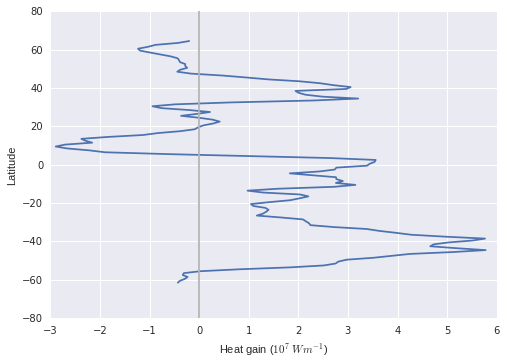

In [155]:
plt.plot(zonal_heat_gain, y)
plt.xlabel('Heat gain ($10^7$ $W m^{-1}$)')
plt.ylabel('Latitude')
plt.axvline(0, color='0.7', linestyle='solid')
plt.show()